## **Single image super-resolution with diffusion probabilistic models (SRDiff)**

This notebook is based on the following:
- Paper: [SRDiff: Single Image Super-Resolution with Diffusion Probabilistic Models](https://arxiv.org/abs/2104.14951)
- Github Repo: [SRDiff's github repo](https://github.com/LeiaLi/SRDiff/tree/main)

In [ ]:
# !pip install lpips

In [16]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch import einsum
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast
from torch.autograd import Variable
from torch.nn import Parameter, init
import torch.distributed as dist

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from PIL import Image
import os
import math
from math import exp
import functools
from functools import partial
from inspect import isfunction
from tqdm import tqdm
from datetime import datetime
import pytz
import copy
import time
import gc
import yaml
import argparse

import subprocess
import re
import lpips
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from __future__ import print_function
from math import ceil, floor

print("imports done!")

imports done!


In [17]:
def get_torch_version():
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed=42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if get_torch_version() <= 1.7:
        #     torch.set_deterministic(True)
        # else:
        #     torch.use_deterministic_algorithms(True)
    print(f"seed {seed} set!")

In [18]:
print("Utility functions created!")

Utility functions created!


In [19]:
get_torch_version()

2.5

In [20]:
# set_seed(42)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [22]:
os.listdir()

['.virtual_documents']

In [23]:
os.listdir("../input/")

['div2k-high-resolution-images', 'srdiff-div2k-pretrained-model']

In [24]:
# enter your own paths...
# the following paths work with my kaggle notebook, when I use the following dataset:
# https://www.kaggle.com/datasets/soumikrakshit/div2k-high-resolution-images
path = "../input/div2k-high-resolution-images/"
train_path = path + "DIV2K_train_HR/DIV2K_train_HR/"
valid_path = path + "DIV2K_valid_HR/DIV2K_valid_HR/"

In [25]:
class DIV2KDataset(Dataset):
    def __init__(self, img_dir_path, scale_factor=4, hr_height=256, hr_width=256, only_img=False):
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height//scale_factor, hr_width//scale_factor), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std),
            ]
        )
        self.img_dir_path = img_dir_path
        self.only_img = only_img


    def __len__(self):
        return len(os.listdir(self.img_dir_path))


    def __getitem__(self, idx):
        img_path = self.img_dir_path + f"{idx:04d}.png"
        img = Image.open(img_path)
        if not self.only_img:
            img_lr = self.lr_transform(img)
            img_hr = self.hr_transform(img)
            return {"lr": img_lr, "hr": img_hr}
        else:
            return img
            

In [26]:
train_dataset = DIV2KDataset(train_path, 4)
val_dataset = DIV2KDataset(valid_path, 4)

index:  228
low resolution shape:  torch.Size([3, 64, 64])
high resolution shape:  torch.Size([3, 256, 256])


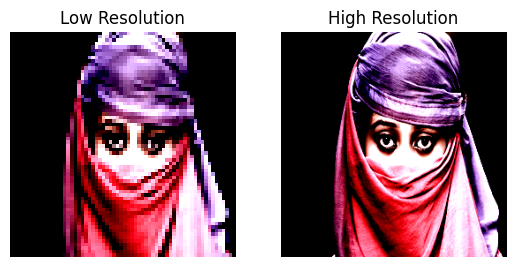

In [27]:
def fn():
    length = len(train_dataset)
    idx = random.randint(0, length-1)
    lr = train_dataset[idx]['lr']
    hr = train_dataset[idx]['hr']
    print("index: ", idx)
    print("low resolution shape: ", lr.shape)
    print("high resolution shape: ", hr.shape)
    lr_img = lr.permute(1, 2, 0).numpy()
    hr_img = hr.permute(1, 2, 0).numpy()
    plt.subplot(1, 2, 1)
    plt.imshow(lr_img)
    plt.axis('off')
    plt.title("Low Resolution")
    plt.subplot(1, 2, 2)
    plt.imshow(hr_img)
    plt.axis('off')
    plt.title("High Resolution")
    plt.show()


fn()

In [28]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


In [29]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def cycle(dl):
    while True:
        for data in dl:
            yield data


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


def initialize_weights(net_l, scale=0.1):
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias.data, 0.0)


def make_layer(block, n_layers, seq=False):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    if seq:
        return nn.Sequential(*layers)
    else:
        return nn.ModuleList(layers)

In [30]:
class ImgMerger:
    def __init__(self, eval_fn):
        self.eval_fn = eval_fn
        self.loc2imgs = {}
        self.max_x = 0
        self.max_y = 0
        self.clear()

    def clear(self):
        self.loc2imgs = {}
        self.max_x = 0
        self.max_y = 0

    def push(self, imgs, loc, loc_bdr):
        """

        Args:
            imgs: each of img is [C, H, W] np.array, range: [0, 255]
            loc: string, e.g., 0_0, 0_1 ...
        """
        self.max_x, self.max_y = loc_bdr
        x, y = loc
        self.loc2imgs[f'{x},{y}'] = imgs
        if len(self.loc2imgs) == self.max_x * self.max_y:
            return self.compute()

    def compute(self):
        img_inputs = []
        for i in range(len(self.loc2imgs['0,0'])):
            img_full = []
            for x in range(self.max_x):
                imgx = []
                for y in range(self.max_y):
                    imgx.append(self.loc2imgs[f'{x},{y}'][i])
                img_full.append(np.concatenate(imgx, 2))
            img_inputs.append(np.concatenate(img_full, 1))
        self.clear()
        return self.eval_fn(*img_inputs)


##########
# SSIM
##########
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        img1 = img1 * 0.5 + 0.5
        img2 = img2 * 0.5 + 0.5
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)


class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=34, use_bn=False, use_input_norm=True):
        super(VGGFeatureExtractor, self).__init__()
        self.use_input_norm = use_input_norm
        if use_bn:
            model = torchvision.models.vgg19_bn(pretrained=True)
        else:
            model = torchvision.models.vgg19(pretrained=True)
        if self.use_input_norm:
            mean = torch.Tensor([0.485 - 1, 0.456 - 1, 0.406 - 1]).view(1, 3, 1, 1)
            # mean = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            # [0.485 - 1, 0.456 - 1, 0.406 - 1] if input in range [-1, 1]
            std = torch.Tensor([0.229 * 2, 0.224 * 2, 0.225 * 2]).view(1, 3, 1, 1)
            # std = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
            # [0.229 * 2, 0.224 * 2, 0.225 * 2] if input in range [-1, 1]
            self.register_buffer('mean', mean)
            self.register_buffer('std', std)
        self.features = nn.Sequential(*list(model.features.children())[:(feature_layer + 1)])
        # No need to BP to variable
        for k, v in self.features.named_parameters():
            v.requires_grad = False

    def forward(self, x):
        # Assume input range is [0, 1]
        if self.use_input_norm:
            x = (x - self.mean) / self.std
        output = self.features(x)
        return output


class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        loss_network = VGGFeatureExtractor()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.l1_loss = nn.L1Loss()

    def forward(self, high_resolution, fake_high_resolution):
        if next(self.loss_network.parameters()).device != high_resolution.device:
            self.loss_network.to(high_resolution.device)
            self.loss_network.eval()
        perception_loss = self.l1_loss(self.loss_network(high_resolution), self.loss_network(fake_high_resolution))
        return perception_loss

In [31]:
global_print_hparams = True
hparams = {}


class Args:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            self.__setattr__(k, v)


def override_config(old_config: dict, new_config: dict):
    for k, v in new_config.items():
        if isinstance(v, dict) and k in old_config:
            override_config(old_config[k], new_config[k])
        else:
            old_config[k] = v


def set_hparams(config='', exp_name='', hparams_str='', print_hparams=True, global_hparams=True):
    if config == '' and exp_name == '':
        parser = argparse.ArgumentParser(description='')
        parser.add_argument('--config', type=str, default='',
                            help='location of the data corpus')
        parser.add_argument('--exp_name', type=str, default='', help='exp_name')
        parser.add_argument('-hp', '--hparams', type=str, default='',
                            help='location of the data corpus')
        parser.add_argument('--infer', action='store_true', help='infer')
        parser.add_argument('--validate', action='store_true', help='validate')
        parser.add_argument('--reset', action='store_true', help='reset hparams')
        parser.add_argument('--debug', action='store_true', help='debug')
        args, unknown = parser.parse_known_args()
        print("| Unknow hparams: ", unknown)
    else:
        args = Args(config=config, exp_name=exp_name, hparams=hparams_str,
                    infer=False, validate=False, reset=False, debug=False)
    global hparams
    assert args.config != '' or args.exp_name != ''
    if args.config != '':
        assert os.path.exists(args.config)

    config_chains = []
    loaded_config = set()

    def load_config(config_fn):
        # deep first inheritance and avoid the second visit of one node
        if not os.path.exists(config_fn):
            return {}
        with open(config_fn) as f:
            hparams_ = yaml.safe_load(f)
        loaded_config.add(config_fn)
        if 'base_config' in hparams_:
            ret_hparams = {}
            if not isinstance(hparams_['base_config'], list):
                hparams_['base_config'] = [hparams_['base_config']]
            for c in hparams_['base_config']:
                if c.startswith('.'):
                    c = f'{os.path.dirname(config_fn)}/{c}'
                    c = os.path.normpath(c)
                if c not in loaded_config:
                    override_config(ret_hparams, load_config(c))
            override_config(ret_hparams, hparams_)
        else:
            ret_hparams = hparams_
        config_chains.append(config_fn)
        return ret_hparams

    saved_hparams = {}
    args_work_dir = ''
    if args.exp_name != '':
        args_work_dir = f'checkpoints/{args.exp_name}'
        ckpt_config_path = f'{args_work_dir}/config.yaml'
        if os.path.exists(ckpt_config_path):
            with open(ckpt_config_path) as f:
                saved_hparams_ = yaml.safe_load(f)
                if saved_hparams_ is not None:
                    saved_hparams.update(saved_hparams_)
    hparams_ = {}
    if args.config != '':
        hparams_.update(load_config(args.config))
    if not args.reset:
        hparams_.update(saved_hparams)
    hparams_['work_dir'] = args_work_dir

    # Support config overriding in command line. Support list type config overriding.
    # Examples: --hparams="a=1,b.c=2,d=[1 1 1]"
    if args.hparams != "":
        for new_hparam in args.hparams.split(","):
            k, v = new_hparam.split("=")
            v = v.strip("\'\" ")
            config_node = hparams_
            for k_ in k.split(".")[:-1]:
                config_node = config_node[k_]
            k = k.split(".")[-1]
            if k not in config_node:
                config_node[k] = v

            elif v in ['True', 'False'] or type(config_node[k]) in [bool, list, dict]:
                if type(config_node[k]) == list:
                    v = v.replace(" ", ",")
                config_node[k] = eval(v)
            else:
                config_node[k] = type(config_node[k])(v)
    if args_work_dir != '' and (not os.path.exists(ckpt_config_path) or args.reset) and not args.infer:
        os.makedirs(hparams_['work_dir'], exist_ok=True)
        with open(ckpt_config_path, 'w') as f:
            yaml.safe_dump(hparams_, f)

    hparams_['infer'] = args.infer
    hparams_['debug'] = args.debug
    hparams_['validate'] = args.validate
    hparams_['exp_name'] = args.exp_name
    global global_print_hparams
    if global_hparams:
        hparams.clear()
        hparams.update(hparams_)
    if print_hparams and global_print_hparams and global_hparams:
        print('| Hparams chains: ', config_chains)
        print('| Hparams: ')
        for i, (k, v) in enumerate(sorted(hparams_.items())):
            print(f"\033[;33;m{k}\033[0m: {v}, ", end="\n" if i % 5 == 4 else "")
        print("")
        global_print_hparams = False
    return hparams_

In [32]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


class Rezero(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        self.g = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.fn(x) * self.g


# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        if groups == 0:
            self.block = nn.Sequential(
                nn.ReflectionPad2d(1),
                nn.Conv2d(dim, dim_out, 3),
                Mish()
            )
        else:
            self.block = nn.Sequential(
                nn.ReflectionPad2d(1),
                nn.Conv2d(dim, dim_out, 3),
                nn.GroupNorm(groups, dim_out),
                Mish()
            )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=0, groups=8):
        super().__init__()
        if time_emb_dim > 0:
            self.mlp = nn.Sequential(
                Mish(),
                nn.Linear(time_emb_dim, dim_out)
            )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None, cond=None):
        h = self.block1(x)
        if time_emb is not None:
            h += self.mlp(time_emb)[:, :, None, None]
        if cond is not None:
            h += cond
        h = self.block2(h)
        return h + self.res_conv(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
        )

    def forward(self, x):
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 2),
        )

    def forward(self, x):
        return self.conv(x)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads=self.heads, qkv=3)
        k = k.softmax(dim=-1)
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)


class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, kdim=None, vdim=None, dropout=0., bias=True,
                 add_bias_kv=False, add_zero_attn=False):
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self.qkv_same_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        self.scaling = self.head_dim ** -0.5
        if self.qkv_same_dim:
            self.in_proj_weight = Parameter(torch.Tensor(3 * embed_dim, embed_dim))
        else:
            self.k_proj_weight = Parameter(torch.Tensor(embed_dim, self.kdim))
            self.v_proj_weight = Parameter(torch.Tensor(embed_dim, self.vdim))
            self.q_proj_weight = Parameter(torch.Tensor(embed_dim, embed_dim))

        if bias:
            self.in_proj_bias = Parameter(torch.Tensor(3 * embed_dim))
        else:
            self.register_parameter('in_proj_bias', None)

        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

        if add_bias_kv:
            self.bias_k = Parameter(torch.Tensor(1, 1, embed_dim))
            self.bias_v = Parameter(torch.Tensor(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self.reset_parameters()

        self.enable_torch_version = False
        if hasattr(F, "multi_head_attention_forward"):
            self.enable_torch_version = True
        else:
            self.enable_torch_version = False
        self.last_attn_probs = None

    def reset_parameters(self):
        if self.qkv_same_dim:
            nn.init.xavier_uniform_(self.in_proj_weight)
        else:
            nn.init.xavier_uniform_(self.k_proj_weight)
            nn.init.xavier_uniform_(self.v_proj_weight)
            nn.init.xavier_uniform_(self.q_proj_weight)

        nn.init.xavier_uniform_(self.out_proj.weight)
        if self.in_proj_bias is not None:
            nn.init.constant_(self.in_proj_bias, 0.)
            nn.init.constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)

    def forward(
            self,
            query, key, value,
            key_padding_mask=None,
            need_weights=True,
            attn_mask=None,
            before_softmax=False,
            need_head_weights=False,
    ):
        """Input shape: [B, T, C]

        Args:
            key_padding_mask (ByteTensor, optional): mask to exclude
                keys that are pads, of shape `(batch, src_len)`, where
                padding elements are indicated by 1s.
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            attn_mask (ByteTensor, optional): typically used to
                implement causal attention, where the mask prevents the
                attention from looking forward in time (default: None).
            before_softmax (bool, optional): return the raw attention
                weights and values before the attention softmax.
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True
        query = query.transpose(0, 1)
        key = key.transpose(0, 1)
        value = value.transpose(0, 1)
        tgt_len, bsz, embed_dim = query.size()
        assert embed_dim == self.embed_dim
        assert list(query.size()) == [tgt_len, bsz, embed_dim]
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias, self.bias_k, self.bias_v,
            self.add_zero_attn, self.dropout, self.out_proj.weight, self.out_proj.bias,
            self.training, key_padding_mask, need_weights, attn_mask)
        attn_output = attn_output.transpose(0, 1)
        return attn_output, attn_output_weights

    def in_proj_qkv(self, query):
        return self._in_proj(query).chunk(3, dim=-1)

    def in_proj_q(self, query):
        if self.qkv_same_dim:
            return self._in_proj(query, end=self.embed_dim)
        else:
            bias = self.in_proj_bias
            if bias is not None:
                bias = bias[:self.embed_dim]
            return F.linear(query, self.q_proj_weight, bias)

    def in_proj_k(self, key):
        if self.qkv_same_dim:
            return self._in_proj(key, start=self.embed_dim, end=2 * self.embed_dim)
        else:
            weight = self.k_proj_weight
            bias = self.in_proj_bias
            if bias is not None:
                bias = bias[self.embed_dim:2 * self.embed_dim]
            return F.linear(key, weight, bias)

    def in_proj_v(self, value):
        if self.qkv_same_dim:
            return self._in_proj(value, start=2 * self.embed_dim)
        else:
            weight = self.v_proj_weight
            bias = self.in_proj_bias
            if bias is not None:
                bias = bias[2 * self.embed_dim:]
            return F.linear(value, weight, bias)

    def _in_proj(self, input, start=0, end=None):
        weight = self.in_proj_weight
        bias = self.in_proj_bias
        weight = weight[start:end, :]
        if bias is not None:
            bias = bias[start:end]
        return F.linear(input, weight, bias)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x

In [33]:
class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        if hparams['sr_scale'] == 8:
            self.upconv3 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x, get_fea=False):
        feas = []
        x = (x + 1) / 2
        fea_first = fea = self.conv_first(x)
        for l in self.RRDB_trunk:
            fea = l(fea)
            feas.append(fea)
        trunk = self.trunk_conv(fea)
        fea = fea_first + trunk
        feas.append(fea)

        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        if hparams['sr_scale'] == 8:
            fea = self.lrelu(self.upconv3(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea_hr = self.HRconv(fea)
        out = self.conv_last(self.lrelu(fea_hr))
        out = out.clamp(0, 1)
        out = out * 2 - 1
        if get_fea:
            return out, feas
        else:
            return out


class Unet(nn.Module):
    def __init__(self, dim, out_dim=None, dim_mults=(1, 2, 4, 8), cond_dim=32):
        super().__init__()
        dims = [3, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        groups = 0

        self.cond_proj = nn.ConvTranspose2d(cond_dim * ((hparams['rrdb_num_block'] + 1) // 3),
                                            dim, hparams['sr_scale'] * 2, hparams['sr_scale'],
                                            hparams['sr_scale'] // 2)

        self.time_pos_emb = SinusoidalPosEmb(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            Mish(),
            nn.Linear(dim * 4, dim)
        )

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_out, time_emb_dim=dim, groups=groups),
                ResnetBlock(dim_out, dim_out, time_emb_dim=dim, groups=groups),
                Downsample(dim_out) if not is_last else nn.Identity()
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=dim, groups=groups)
        if hparams['use_attn']:
            self.mid_attn = Residual(Rezero(LinearAttention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=dim, groups=groups)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(nn.ModuleList([
                ResnetBlock(dim_out * 2, dim_in, time_emb_dim=dim, groups=groups),
                ResnetBlock(dim_in, dim_in, time_emb_dim=dim, groups=groups),
                Upsample(dim_in) if not is_last else nn.Identity()
            ]))

        self.final_conv = nn.Sequential(
            Block(dim, dim, groups=groups),
            nn.Conv2d(dim, out_dim, 1)
        )

        if hparams['res'] and hparams['up_input']:
            self.up_proj = nn.Sequential(
                nn.ReflectionPad2d(1), nn.Conv2d(3, dim, 3),
            )
        if hparams['use_wn']:
            self.apply_weight_norm()
        if hparams['weight_init']:
            self.apply(initialize_weights)

    def apply_weight_norm(self):
        def _apply_weight_norm(m):
            if isinstance(m, torch.nn.Conv1d) or isinstance(m, torch.nn.Conv2d):
                torch.nn.utils.weight_norm(m)
                # print(f"| Weight norm is applied to {m}.")

        self.apply(_apply_weight_norm)

    def forward(self, x, time, cond, img_lr_up):
        t = self.time_pos_emb(time)
        t = self.mlp(t)

        h = []
        cond = self.cond_proj(torch.cat(cond[2::3], 1))
        for i, (resnet, resnet2, downsample) in enumerate(self.downs):
            x = resnet(x, t)
            x = resnet2(x, t)
            if i == 0:
                x = x + cond
                if hparams['res'] and hparams['up_input']:
                    x = x + self.up_proj(img_lr_up)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        if hparams['use_attn']:
            x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for resnet, resnet2, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, t)
            x = resnet2(x, t)
            x = upsample(x)

        return self.final_conv(x)

    def make_generation_fast_(self):
        def remove_weight_norm(m):
            try:
                nn.utils.remove_weight_norm(m)
            except ValueError:  # this module didn't have weight norm
                return

        self.apply(remove_weight_norm)

In [34]:
# gaussian diffusion trainer class
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, warmup_frac):
    betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    warmup_time = int(num_diffusion_timesteps * warmup_frac)
    betas[:warmup_time] = np.linspace(beta_start, beta_end, warmup_time, dtype=np.float64)
    return betas


def get_beta_schedule(num_diffusion_timesteps, beta_schedule='linear', beta_start=0.0001, beta_end=0.02):
    if beta_schedule == 'quad':
        betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=np.float64) ** 2
    elif beta_schedule == 'linear':
        betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == 'warmup10':
        betas = _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, 0.1)
    elif beta_schedule == 'warmup50':
        betas = _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, 0.5)
    elif beta_schedule == 'const':
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64)
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, steps, steps)
    alphas_cumprod = np.cos(((x / steps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, a_min=0, a_max=0.999)


class GaussianDiffusion(nn.Module):
    def __init__(self, denoise_fn, rrdb_net, timesteps=1000, loss_type='l1'):
        super().__init__()
        self.denoise_fn = denoise_fn
        # condition net
        self.rrdb = rrdb_net
        self.ssim_loss = SSIM(window_size=11)
        if hparams['aux_percep_loss']:
            self.percep_loss_fn = [PerceptualLoss()]

        if hparams['beta_schedule'] == 'cosine':
            betas = cosine_beta_schedule(timesteps, s=hparams['beta_s'])
        if hparams['beta_schedule'] == 'linear':
            betas = get_beta_schedule(timesteps, beta_end=hparams['beta_end'])
            if hparams['res']:
                betas[-1] = 0.999

        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance', to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))
        self.sample_tqdm = True

    def q_mean_variance(self, x_start, t):
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1. - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
                extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
                extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
                extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, noise_pred, clip_denoised: bool):
        x_recon = self.predict_start_from_noise(x, t=t, noise=noise_pred)

        if clip_denoised:
            x_recon.clamp_(-1.0, 1.0)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance, x_recon

    def forward(self, img_hr, img_lr, img_lr_up, t=None, *args, **kwargs):
        x = img_hr
        b, *_, device = *x.shape, x.device
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long() \
            if t is None else torch.LongTensor([t]).repeat(b).to(device)
        if hparams['use_rrdb']:
            if hparams['fix_rrdb']:
                self.rrdb.eval()
                with torch.no_grad():
                    rrdb_out, cond = self.rrdb(img_lr, True)
            else:
                rrdb_out, cond = self.rrdb(img_lr, True)
        else:
            rrdb_out = img_lr_up
            cond = img_lr
        x = self.img2res(x, img_lr_up)
        p_losses, x_tp1, noise_pred, x_t, x_t_gt, x_0 = self.p_losses(x, t, cond, img_lr_up, *args, **kwargs)
        ret = {'q': p_losses}
        if not hparams['fix_rrdb']:
            if hparams['aux_l1_loss']:
                ret['aux_l1'] = F.l1_loss(rrdb_out, img_hr)
            if hparams['aux_ssim_loss']:
                ret['aux_ssim'] = 1 - self.ssim_loss(rrdb_out, img_hr)
            if hparams['aux_percep_loss']:
                ret['aux_percep'] = self.percep_loss_fn[0](img_hr, rrdb_out)
        # x_recon = self.res2img(x_recon, img_lr_up)
        x_tp1 = self.res2img(x_tp1, img_lr_up)
        x_t = self.res2img(x_t, img_lr_up)
        x_t_gt = self.res2img(x_t_gt, img_lr_up)
        return ret, (x_tp1, x_t_gt, x_t), t

    def p_losses(self, x_start, t, cond, img_lr_up, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_tp1_gt = self.q_sample(x_start=x_start, t=t, noise=noise)
        x_t_gt = self.q_sample(x_start=x_start, t=t - 1, noise=noise)
        noise_pred = self.denoise_fn(x_tp1_gt, t, cond, img_lr_up)
        x_t_pred, x0_pred = self.p_sample(x_tp1_gt, t, cond, img_lr_up, noise_pred=noise_pred)

        if self.loss_type == 'l1':
            loss = (noise - noise_pred).abs().mean()
        elif self.loss_type == 'l2':
            loss = F.mse_loss(noise, noise_pred)
        elif self.loss_type == 'ssim':
            loss = (noise - noise_pred).abs().mean()
            loss = loss + (1 - self.ssim_loss(noise, noise_pred))
        else:
            raise NotImplementedError()
        return loss, x_tp1_gt, noise_pred, x_t_pred, x_t_gt, x0_pred

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        t_cond = (t[:, None, None, None] >= 0).float()
        t = t.clamp_min(0)
        return (
                       extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
                       extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
               ) * t_cond + x_start * (1 - t_cond)

    @torch.no_grad()
    def p_sample(self, x, t, cond, img_lr_up, noise_pred=None, clip_denoised=True, repeat_noise=False):
        if noise_pred is None:
            noise_pred = self.denoise_fn(x, t, cond=cond, img_lr_up=img_lr_up)
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance, x0_pred = self.p_mean_variance(
            x=x, t=t, noise_pred=noise_pred, clip_denoised=clip_denoised)
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise, x0_pred

    @torch.no_grad()
    def sample(self, img_lr, img_lr_up, shape, save_intermediate=False):
        device = self.betas.device
        b = shape[0]
        if not hparams['res']:
            t = torch.full((b,), self.num_timesteps - 1, device=device, dtype=torch.long)
            img = self.q_sample(img_lr_up, t)
        else:
            img = torch.randn(shape, device=device)
        if hparams['use_rrdb']:
            rrdb_out, cond = self.rrdb(img_lr, True)
        else:
            rrdb_out = img_lr_up
            cond = img_lr
        it = reversed(range(0, self.num_timesteps))
        if self.sample_tqdm:
            it = tqdm(it, desc='sampling loop time step', total=self.num_timesteps)
        images = []
        for i in it:
            img, x_recon = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long), cond, img_lr_up)
            if save_intermediate:
                img_ = self.res2img(img, img_lr_up)
                x_recon_ = self.res2img(x_recon, img_lr_up)
                images.append((img_.cpu(), x_recon_.cpu()))
        img = self.res2img(img, img_lr_up)
        if save_intermediate:
            return img, rrdb_out, images
        else:
            return img, rrdb_out

    @torch.no_grad()
    def interpolate(self, x1, x2, img_lr, img_lr_up, t=None, lam=0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)
        if hparams['use_rrdb']:
            rrdb_out, cond = self.rrdb(img_lr, True)
        else:
            cond = img_lr

        assert x1.shape == x2.shape

        x1 = self.img2res(x1, img_lr_up)
        x2 = self.img2res(x2, img_lr_up)

        t_batched = torch.stack([torch.tensor(t, device=device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t=t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2
        for i in tqdm(reversed(range(0, t)), desc='interpolation sample time step', total=t):
            img, x_recon = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long), cond, img_lr_up)

        img = self.res2img(img, img_lr_up)
        return img

    def res2img(self, img_, img_lr_up, clip_input=None):
        if clip_input is None:
            clip_input = hparams['clip_input']
        if hparams['res']:
            if clip_input:
                img_ = img_.clamp(-1, 1)
            img_ = img_ / hparams['res_rescale'] + img_lr_up
        return img_

    def img2res(self, x, img_lr_up, clip_input=None):
        if clip_input is None:
            clip_input = hparams['clip_input']
        if hparams['res']:
            x = (x - img_lr_up) * hparams['res_rescale']
            if clip_input:
                x = x.clamp(-1, 1)
        return x

In [35]:
# https://github.com/fatheral/matlab_imresize
#
# MIT License
#
# Copyright (c) 2020 Alex
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


def deriveSizeFromScale(img_shape, scale):
    output_shape = []
    for k in range(2):
        output_shape.append(int(ceil(scale[k] * img_shape[k])))
    return output_shape


def deriveScaleFromSize(img_shape_in, img_shape_out):
    scale = []
    for k in range(2):
        scale.append(1.0 * img_shape_out[k] / img_shape_in[k])
    return scale


def triangle(x):
    x = np.array(x).astype(np.float64)
    lessthanzero = np.logical_and((x >= -1), x < 0)
    greaterthanzero = np.logical_and((x <= 1), x >= 0)
    f = np.multiply((x + 1), lessthanzero) + np.multiply((1 - x), greaterthanzero)
    return f


def cubic(x):
    x = np.array(x).astype(np.float64)
    absx = np.absolute(x)
    absx2 = np.multiply(absx, absx)
    absx3 = np.multiply(absx2, absx)
    f = np.multiply(1.5 * absx3 - 2.5 * absx2 + 1, absx <= 1) + np.multiply(-0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2,
                                                                            (1 < absx) & (absx <= 2))
    return f


def contributions(in_length, out_length, scale, kernel, k_width):
    if scale < 1:
        h = lambda x: scale * kernel(scale * x)
        kernel_width = 1.0 * k_width / scale
    else:
        h = kernel
        kernel_width = k_width
    x = np.arange(1, out_length + 1).astype(np.float64)
    u = x / scale + 0.5 * (1 - 1 / scale)
    left = np.floor(u - kernel_width / 2)
    P = int(ceil(kernel_width)) + 2
    ind = np.expand_dims(left, axis=1) + np.arange(P) - 1  # -1 because indexing from 0
    indices = ind.astype(np.int32)
    weights = h(np.expand_dims(u, axis=1) - indices - 1)  # -1 because indexing from 0
    weights = np.divide(weights, np.expand_dims(np.sum(weights, axis=1), axis=1))
    aux = np.concatenate((np.arange(in_length), np.arange(in_length - 1, -1, step=-1))).astype(np.int32)
    indices = aux[np.mod(indices, aux.size)]
    ind2store = np.nonzero(np.any(weights, axis=0))
    weights = weights[:, ind2store]
    indices = indices[:, ind2store]
    return weights, indices


def imresizemex(inimg, weights, indices, dim):
    in_shape = inimg.shape
    w_shape = weights.shape
    out_shape = list(in_shape)
    out_shape[dim] = w_shape[0]
    outimg = np.zeros(out_shape)
    if dim == 0:
        for i_img in range(in_shape[1]):
            for i_w in range(w_shape[0]):
                w = weights[i_w, :]
                ind = indices[i_w, :]
                im_slice = inimg[ind, i_img].astype(np.float64)
                outimg[i_w, i_img] = np.sum(np.multiply(np.squeeze(im_slice, axis=0), w.T), axis=0)
    elif dim == 1:
        for i_img in range(in_shape[0]):
            for i_w in range(w_shape[0]):
                w = weights[i_w, :]
                ind = indices[i_w, :]
                im_slice = inimg[i_img, ind].astype(np.float64)
                outimg[i_img, i_w] = np.sum(np.multiply(np.squeeze(im_slice, axis=0), w.T), axis=0)
    if inimg.dtype == np.uint8:
        outimg = np.clip(outimg, 0, 255)
        return np.around(outimg).astype(np.uint8)
    else:
        return outimg


def imresizevec(inimg, weights, indices, dim):
    wshape = weights.shape
    if dim == 0:
        weights = weights.reshape((wshape[0], wshape[2], 1, 1))
        outimg = np.sum(weights * ((inimg[indices].squeeze(axis=1)).astype(np.float64)), axis=1)
    elif dim == 1:
        weights = weights.reshape((1, wshape[0], wshape[2], 1))
        outimg = np.sum(weights * ((inimg[:, indices].squeeze(axis=2)).astype(np.float64)), axis=2)
    if inimg.dtype == np.uint8:
        outimg = np.clip(outimg, 0, 255)
        return np.around(outimg).astype(np.uint8)
    else:
        return outimg


def resizeAlongDim(A, dim, weights, indices, mode="vec"):
    if mode == "org":
        out = imresizemex(A, weights, indices, dim)
    else:
        out = imresizevec(A, weights, indices, dim)
    return out


def imresize(I, scale=None, method='bicubic', sizes=None, mode="vec"):
    if method == 'bicubic':
        kernel = cubic
    elif method == 'bilinear':
        kernel = triangle
    else:
        print('Error: Unidentified method supplied')

    kernel_width = 4.0
    # Fill scale and output_size
    if scale is not None:
        scale = float(scale)
        scale = [scale, scale]
        output_size = deriveSizeFromScale(I.shape, scale)
    elif sizes is not None:
        scale = deriveScaleFromSize(I.shape, sizes)
        output_size = list(sizes)
    else:
        print('Error: scalar_scale OR output_shape should be defined!')
        return
    scale_np = np.array(scale)
    order = np.argsort(scale_np)
    weights = []
    indices = []
    for k in range(2):
        w, ind = contributions(I.shape[k], output_size[k], scale[k], kernel, kernel_width)
        weights.append(w)
        indices.append(ind)
    B = np.copy(I)
    flag2D = False
    if B.ndim == 2:
        B = np.expand_dims(B, axis=2)
        flag2D = True
    for k in range(2):
        dim = order[k]
        B = resizeAlongDim(B, dim, weights[dim], indices[dim], mode)
    if flag2D:
        B = np.squeeze(B, axis=2)
    return B


def convertDouble2Byte(I):
    B = np.clip(I, 0.0, 1.0)
    B = 255 * B
    return np.around(B).astype(np.uint8)


def reduce_tensors(metrics):
    new_metrics = {}
    for k, v in metrics.items():
        if isinstance(v, torch.Tensor):
            dist.all_reduce(v)
            v = v / dist.get_world_size()
        if type(v) is dict:
            v = reduce_tensors(v)
        new_metrics[k] = v
    return new_metrics


def tensors_to_scalars(tensors):
    if isinstance(tensors, torch.Tensor):
        tensors = tensors.item()
        return tensors
    elif isinstance(tensors, dict):
        new_tensors = {}
        for k, v in tensors.items():
            v = tensors_to_scalars(v)
            new_tensors[k] = v
        return new_tensors
    elif isinstance(tensors, list):
        return [tensors_to_scalars(v) for v in tensors]
    else:
        return tensors


def tensors_to_np(tensors):
    if isinstance(tensors, dict):
        new_np = {}
        for k, v in tensors.items():
            if isinstance(v, torch.Tensor):
                v = v.cpu().numpy()
            if type(v) is dict:
                v = tensors_to_np(v)
            new_np[k] = v
    elif isinstance(tensors, list):
        new_np = []
        for v in tensors:
            if isinstance(v, torch.Tensor):
                v = v.cpu().numpy()
            if type(v) is dict:
                v = tensors_to_np(v)
            new_np.append(v)
    elif isinstance(tensors, torch.Tensor):
        v = tensors
        if isinstance(v, torch.Tensor):
            v = v.cpu().numpy()
        if type(v) is dict:
            v = tensors_to_np(v)
        new_np = v
    else:
        raise Exception(f'tensors_to_np does not support type {type(tensors)}.')
    return new_np


def move_to_cpu(tensors):
    ret = {}
    for k, v in tensors.items():
        if isinstance(v, torch.Tensor):
            v = v.cpu()
        if type(v) is dict:
            v = move_to_cpu(v)
        ret[k] = v
    return ret


def move_to_cuda(batch, gpu_id=0):
    # base case: object can be directly moved using `cuda` or `to`
    if callable(getattr(batch, 'cuda', None)):
        return batch.cuda(gpu_id, non_blocking=True)
    elif callable(getattr(batch, 'to', None)):
        return batch.to(torch.device('cuda', gpu_id), non_blocking=True)
    elif isinstance(batch, list):
        for i, x in enumerate(batch):
            batch[i] = move_to_cuda(x, gpu_id)
        return batch
    elif isinstance(batch, tuple):
        batch = list(batch)
        for i, x in enumerate(batch):
            batch[i] = move_to_cuda(x, gpu_id)
        return tuple(batch)
    elif isinstance(batch, dict):
        for k, v in batch.items():
            batch[k] = move_to_cuda(v, gpu_id)
        return batch
    return batch


def get_last_checkpoint(work_dir, steps=None):
    checkpoint = None
    last_ckpt_path = None
    ckpt_paths = get_all_ckpts(work_dir, steps)
    if len(ckpt_paths) > 0:
        last_ckpt_path = ckpt_paths[0]
        checkpoint = torch.load(last_ckpt_path, map_location='cpu')
    return checkpoint, last_ckpt_path


def get_all_ckpts(work_dir, steps=None):
    if steps is None:
        ckpt_path_pattern = f'{work_dir}/model_ckpt_steps_*.ckpt'
    else:
        ckpt_path_pattern = f'{work_dir}/model_ckpt_steps_{steps}.ckpt'
    return sorted(glob.glob(ckpt_path_pattern),
                  key=lambda x: -int(re.findall('.*steps\_(\d+)\.ckpt', x)[0]))


def load_checkpoint(model, optimizer, work_dir):
    checkpoint, _ = get_last_checkpoint(work_dir)
    if checkpoint is not None:
        model.load_state_dict(checkpoint['state_dict']['model'])
        model.cuda()
        optimizer.load_state_dict(checkpoint['optimizer_states'][0])
        training_step = checkpoint['global_step']
        del checkpoint
        torch.cuda.empty_cache()
    else:
        training_step = 0
        model.cuda()
    return training_step


def save_checkpoint(model, optimizer, work_dir, global_step, num_ckpt_keep):
    ckpt_path = f'{work_dir}/model_ckpt_steps_{global_step}.ckpt'
    print(f'Step@{global_step}: saving model to {ckpt_path}')
    checkpoint = {'global_step': global_step}
    optimizer_states = []
    optimizer_states.append(optimizer.state_dict())
    checkpoint['optimizer_states'] = optimizer_states
    checkpoint['state_dict'] = {'model': model.state_dict()}
    torch.save(checkpoint, ckpt_path, _use_new_zipfile_serialization=False)
    for old_ckpt in get_all_ckpts(work_dir)[num_ckpt_keep:]:
        remove_file(old_ckpt)
        print(f'Delete ckpt: {os.path.basename(old_ckpt)}')


def remove_file(*fns):
    for f in fns:
        subprocess.check_call(f'rm -rf "{f}"', shell=True)


def plot_img(img):
    img = img.data.cpu().numpy()
    return np.clip(img, 0, 1)


def load_ckpt(cur_model, ckpt_base_dir, model_name='model', force=True, strict=True):
    if os.path.isfile(ckpt_base_dir):
        base_dir = os.path.dirname(ckpt_base_dir)
        ckpt_path = ckpt_base_dir
        checkpoint = torch.load(ckpt_base_dir, map_location='cpu')
    else:
        base_dir = ckpt_base_dir
        checkpoint, ckpt_path = get_last_checkpoint(ckpt_base_dir)
    if checkpoint is not None:
        state_dict = checkpoint["state_dict"]
        if len([k for k in state_dict.keys() if '.' in k]) > 0:
            state_dict = {k[len(model_name) + 1:]: v for k, v in state_dict.items()
                          if k.startswith(f'{model_name}.')}
        else:
            state_dict = state_dict[model_name]
        if not strict:
            cur_model_state_dict = cur_model.state_dict()
            unmatched_keys = []
            for key, param in state_dict.items():
                if key in cur_model_state_dict:
                    new_param = cur_model_state_dict[key]
                    if new_param.shape != param.shape:
                        unmatched_keys.append(key)
                        print("| Unmatched keys: ", key, new_param.shape, param.shape)
            for key in unmatched_keys:
                del state_dict[key]
        cur_model.load_state_dict(state_dict, strict=strict)
        print(f"| load '{model_name}' from '{ckpt_path}'.")
    else:
        e_msg = f"| ckpt not found in {base_dir}."
        if force:
            assert False, e_msg
        else:
            print(e_msg)


class Measure:
    def __init__(self, net='alex'):
        self.model = lpips.LPIPS(net=net)

    def measure(self, imgA, imgB, img_lr, sr_scale):
        """

        Args:
            imgA: [C, H, W] uint8 or torch.FloatTensor [-1,1]
            imgB: [C, H, W] uint8 or torch.FloatTensor [-1,1]
            img_lr: [C, H, W] uint8  or torch.FloatTensor [-1,1]
            sr_scale:

        Returns: dict of metrics

        """
        if isinstance(imgA, torch.Tensor):
            imgA = np.round((imgA.cpu().numpy() + 1) * 127.5).clip(min=0, max=255).astype(np.uint8)
            imgB = np.round((imgB.cpu().numpy() + 1) * 127.5).clip(min=0, max=255).astype(np.uint8)
            img_lr = np.round((img_lr.cpu().numpy() + 1) * 127.5).clip(min=0, max=255).astype(np.uint8)
        imgA = imgA.transpose(1, 2, 0)
        imgA_lr = imresize(imgA, 1 / sr_scale)
        imgB = imgB.transpose(1, 2, 0)
        img_lr = img_lr.transpose(1, 2, 0)
        psnr = self.psnr(imgA, imgB)
        ssim = self.ssim(imgA, imgB)
        lpips = self.lpips(imgA, imgB)
        lr_psnr = self.psnr(imgA_lr, img_lr)
        res = {'psnr': psnr, 'ssim': ssim, 'lpips': lpips, 'lr_psnr': lr_psnr}
        return {k: float(v) for k, v in res.items()}

    def lpips(self, imgA, imgB, model=None):
        device = next(self.model.parameters()).device
        tA = t(imgA).to(device)
        tB = t(imgB).to(device)
        dist01 = self.model.forward(tA, tB).item()
        return dist01

    def ssim(self, imgA, imgB):
        score, diff = ssim(imgA, imgB, full=True, multichannel=True, data_range=255)
        return score

    def psnr(self, imgA, imgB):
        return psnr(imgA, imgB, data_range=255)


def t(img):
    def to_4d(img):
        assert len(img.shape) == 3
        img_new = np.expand_dims(img, axis=0)
        assert len(img_new.shape) == 4
        return img_new

    def to_CHW(img):
        return np.transpose(img, [2, 0, 1])

    def to_tensor(img):
        return torch.Tensor(img)

    return to_tensor(to_4d(to_CHW(img))) / 127.5 - 1

In [36]:
os.listdir("../input/srdiff-div2k-pretrained-model/")

['config.yaml', 'model_ckpt_steps_400000.ckpt']

In [37]:
pretrained_model_path = "../input/srdiff-div2k-pretrained-model/"

In [38]:
with open(pretrained_model_path+'config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config

{'accumulate_grad_batches': 1,
 'amp': False,
 'aux_l1_loss': True,
 'aux_percep_loss': False,
 'aux_ssim_loss': False,
 'base_config': ['./diffsr_base.yaml', './df2k4x.yaml'],
 'batch_size': 64,
 'beta_end': 0.02,
 'beta_s': 0.008,
 'beta_schedule': 'cosine',
 'binary_data_dir': 'data/binary/df2k4x',
 'check_val_every_n_epoch': 10,
 'clip_grad_norm': 10,
 'clip_input': True,
 'crop_size': 320,
 'data_augmentation': False,
 'data_interp': 'bicubic',
 'debug': False,
 'decay_steps': 200000,
 'denoise_fn': 'unet',
 'ds_workers': 1,
 'endless': False,
 'eval_batch_size': 1,
 'fix_rrdb': True,
 'gen_dir_name': '',
 'gn_groups': 0,
 'hidden_size': 64,
 'infer': False,
 'load_ckpt': '',
 'loss_type': 'l1',
 'lr': 0.0002,
 'max_epochs': 1000,
 'max_updates': 400000,
 'num_ckpt_keep': 100,
 'num_sanity_val_steps': 4,
 'num_workers': 8,
 'patch_size': 160,
 'pred_noise': True,
 'print_arch': False,
 'print_nan_grads': False,
 'res': True,
 'res_rescale': 2.0,
 'resume_from_checkpoint': 0,
 'rrd

In [39]:
# ----------------------------
# 1. Load YAML configuration
# ----------------------------
config_path = "../input/srdiff-div2k-pretrained-model/config.yaml"
with open(config_path, "r") as f:
    hparams = yaml.safe_load(f)

# Set inference flag and checkpoint path
hparams['infer'] = True
hparams['load_ckpt'] = "../input/srdiff-div2k-pretrained-model/model_ckpt_steps_400000.ckpt"

# Convert unet_dim_mults string to tuple if needed (e.g., "1|2|3|4")
if isinstance(hparams.get('unet_dim_mults', None), str):
    hparams['unet_dim_mults'] = tuple(map(int, hparams['unet_dim_mults'].split('|')))

# ----------------------------
# 2. Define image transforms
# ----------------------------
hr_height, hr_width = 256, 256
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((hr_height, hr_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def upsample_tensor(tensor, scale_factor):
    """Upsample a tensor using bicubic interpolation."""
    tensor = tensor.unsqueeze(0)  # add batch dimension
    upsampled = F.interpolate(tensor, scale_factor=scale_factor, mode='bicubic', align_corners=True)
    return upsampled.squeeze(0)

# ----------------------------
# 3. Build (simplified) Model
# ----------------------------
# For inference we need the RRDB branch (if used) and the Unet denoiser, then the diffusion model.
# NOTE: In your real code, use the full implementations from the repo.

# A minimal RRDBNet (placeholder)
class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        # Replace this with the full RRDBNet architecture
        self.conv = nn.Conv2d(in_nc, out_nc, 3, 1, 1)
    def forward(self, x, return_features=False):
        out = self.conv(x)
        return out, x  # dummy features

# Instantiate RRDB network if used
if hparams.get('use_rrdb', True):
    rrdb_net = RRDBNet(3, 3, 64, hparams.get('rrdb_num_block', 8), gc=32)
else:
    rrdb_net = None

# A minimal Unet denoiser (placeholder)
class Unet(nn.Module):
    def __init__(self, dim, out_dim, dim_mults, cond_dim=32):
        super().__init__()
        # Replace this with the full Unet implementation
        self.conv = nn.Conv2d(3, out_dim, 3, 1, 1)
    def forward(self, x, time, cond, img_lr_up):
        return self.conv(x)

unet = Unet(dim=hparams.get('hidden_size', 64), 
            out_dim=3, 
            dim_mults=hparams['unet_dim_mults'], 
            cond_dim=32)

diffusion = GaussianDiffusion(denoise_fn=unet, 
                              rrdb_net=rrdb_net, 
                              timesteps=hparams.get('timesteps', 100), 
                              loss_type=hparams.get('loss_type', 'l1'))

# ----------------------------
# 4. Load Pretrained Weights
# ----------------------------
ckpt_path = hparams.get('load_ckpt')
if ckpt_path is not None and os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=True)
    state_dict = checkpoint["state_dict"]
    # You might need to adjust keys depending on how they were saved.
    diffusion.load_state_dict(state_dict, strict=False)
    print("Pretrained checkpoint loaded.")
else:
    print("Checkpoint not found!")

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion = diffusion.to(device)
unet = unet.to(device)
if rrdb_net is not None:
    rrdb_net = rrdb_net.to(device)



Pretrained checkpoint loaded.


In [40]:
def model_inference(image):
    # Preprocess: resize and normalize
    img_lr = transform(image)
    # Upsample to high resolution using bicubic interpolation (scale factor from config)
    sr_scale = hparams.get('sr_scale', 4)
    img_lr_up = upsample_tensor(img_lr, scale_factor=sr_scale)
    
    # Add batch dimension and send to GPU
    img_lr = img_lr.unsqueeze(0).to(device)
    img_lr_up = img_lr_up.unsqueeze(0).to(device)
    
    # Define the shape for sampling (batch, channels, height, width)
    shape = img_lr_up.shape
    
    # Run the diffusion sampling (set model to eval mode)
    diffusion.eval()
    with torch.no_grad():
        enhanced, _ = diffusion.sample(img_lr, img_lr_up, shape, save_intermediate=False)
    
    # Convert enhanced output from [-1,1] to [0,1] for display
    enhanced_img = enhanced.squeeze(0).cpu().clamp(-1, 1)
    enhanced_img = (enhanced_img + 1) / 2
    enhanced_img = enhanced_img.permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(8,8))
    plt.imshow(enhanced_img)
    plt.axis('off')
    plt.title("Enhanced Image")
    plt.show()


In [41]:
test_dataset = DIV2KDataset(valid_path, 4, only_img=True)
length = len(test_dataset)
idx = random.randint(801, 900)
# test_dataset[idx]

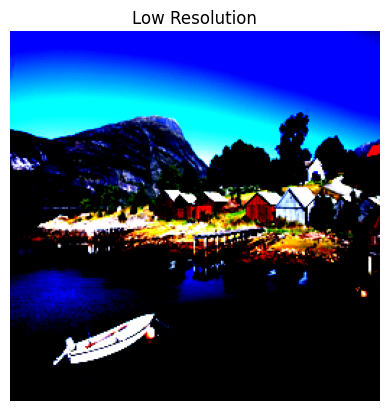

In [42]:
def fn():
    lr = transform(test_dataset[idx])
    lr_img = lr.permute(1, 2, 0).numpy()
    plt.imshow(lr_img)
    plt.axis('off')
    plt.title("Low Resolution")
    plt.show()

fn()

High Resolution image:


sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


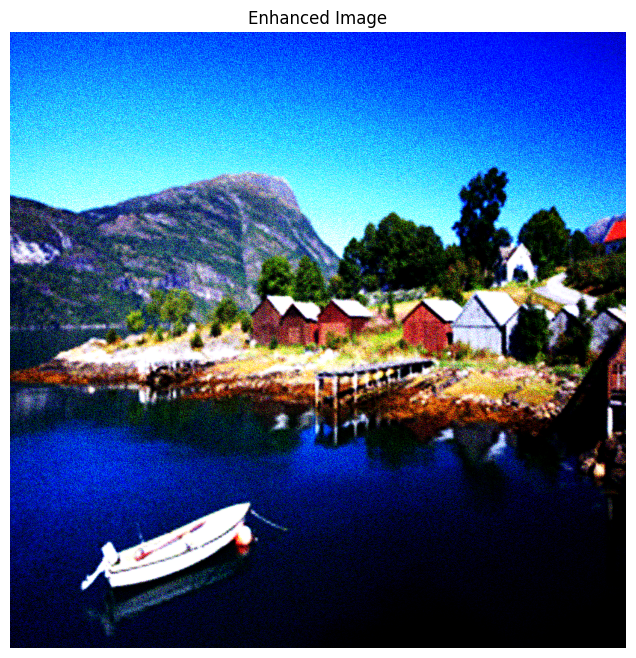

In [43]:
img = test_dataset[idx]
print("High Resolution image:")
model_inference(img)

In [44]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!
